In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import utils
import os

In [2]:
from dotenv import load_dotenv
load_dotenv()
HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")
os.environ["HOPSWORKS_API_KEY"] = HOPSWORKS_API_KEY

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
yesterday = today - datetime.timedelta(days = 1)
today

datetime.datetime(2025, 1, 22, 9, 57, 12, 483158)

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 

2025-01-22 09:57:12,516 INFO: Initializing external client
2025-01-22 09:57:12,517 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-22 09:57:13,996 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1207494


In [5]:
CITY = "dublin"
STATION = "HEUSTON BRIDGE (NORTH)"

STATION = STATION.replace(" ", "_")

In [6]:
feature_view = fs.get_feature_view(
    name='bike_weather_fw',
    version=1,
)

In [7]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="bike_availability_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [8]:
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
# retrieved_xgboost_model

In [9]:
weather_fg = fs.get_feature_group(
    name='weather_data',
    version=1,
)

batch_data = weather_fg.filter(weather_fg.datetime >= today).read()
batch_data["month"] = batch_data["datetime"].dt.month
batch_data["weekday"] = batch_data["datetime"].dt.weekday  # 0=Monday, 6=Sunday
batch_data["hour"] = batch_data["datetime"].dt.hour
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.66s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour
0,2025-01-26 02:00:00+00:00,0.80,-4.023707,0.0,0.0,17.673029,31026.716797,5.400000,dublin,1,6,2
1,2025-01-22 17:00:00+00:00,5.10,2.621218,0.0,0.0,6.489992,30252.697266,0.900000,dublin,1,2,17
2,2025-01-23 19:00:00+00:00,3.75,-1.204180,0.0,0.0,17.782688,30442.521484,2.900000,dublin,1,3,19
3,2025-01-29 21:00:00+00:00,4.70,-1.933103,0.0,0.0,31.205997,31637.470703,9.000000,dublin,1,2,21
4,2025-01-29 19:00:00+00:00,5.15,-1.790049,0.0,0.0,33.994751,31637.470703,9.000000,dublin,1,2,19
...,...,...,...,...,...,...,...,...,...,...,...,...
224,2025-01-31 11:00:00+00:00,6.50,3.481879,0.0,0.0,9.085988,32065.236328,5.700001,dublin,1,4,11
225,2025-01-31 22:00:00+00:00,6.25,1.161357,0.3,0.0,25.478743,32065.236328,5.700001,dublin,1,4,22
226,2025-01-31 15:00:00+00:00,7.65,4.674398,0.7,0.0,12.727921,32065.236328,5.700001,dublin,1,4,15
227,2025-01-31 03:00:00+00:00,5.40,0.109161,0.0,0.0,22.530937,32065.236328,5.700001,dublin,1,4,3


## Creating predictions

In [10]:
batch_data['predicted_bikes_available'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'weekday', 'hour']]
)
batch_data['predicted_bikes_available'] = batch_data['predicted_bikes_available'].apply(lambda x: round(x))

batch_data

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available
0,2025-01-26 02:00:00+00:00,0.80,-4.023707,0.0,0.0,17.673029,31026.716797,5.400000,dublin,1,6,2,34
1,2025-01-22 17:00:00+00:00,5.10,2.621218,0.0,0.0,6.489992,30252.697266,0.900000,dublin,1,2,17,13
2,2025-01-23 19:00:00+00:00,3.75,-1.204180,0.0,0.0,17.782688,30442.521484,2.900000,dublin,1,3,19,42
3,2025-01-29 21:00:00+00:00,4.70,-1.933103,0.0,0.0,31.205997,31637.470703,9.000000,dublin,1,2,21,44
4,2025-01-29 19:00:00+00:00,5.15,-1.790049,0.0,0.0,33.994751,31637.470703,9.000000,dublin,1,2,19,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,2025-01-31 11:00:00+00:00,6.50,3.481879,0.0,0.0,9.085988,32065.236328,5.700001,dublin,1,4,11,25
225,2025-01-31 22:00:00+00:00,6.25,1.161357,0.3,0.0,25.478743,32065.236328,5.700001,dublin,1,4,22,34
226,2025-01-31 15:00:00+00:00,7.65,4.674398,0.7,0.0,12.727921,32065.236328,5.700001,dublin,1,4,15,21
227,2025-01-31 03:00:00+00:00,5.40,0.109161,0.0,0.0,22.530937,32065.236328,5.700001,dublin,1,4,3,35


In [11]:
# Fill in the number of hours before the time on which you made the forecast (base_datetime)
batch_data = batch_data.sort_values(by=['datetime'])
batch_data['hours_before_forecast_time'] = range(1, len(batch_data) + 1)
batch_data

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available,hours_before_forecast_time
138,2025-01-22 11:00:00+00:00,4.25,1.297898,0.0,0.0,10.239453,30252.697266,0.900000,dublin,1,2,11,2,1
180,2025-01-22 12:00:00+00:00,4.75,1.802121,0.0,0.0,10.483357,30252.697266,0.900000,dublin,1,2,12,4,2
187,2025-01-22 13:00:00+00:00,5.15,2.175007,0.0,0.0,10.587917,30252.697266,0.900000,dublin,1,2,13,3,3
63,2025-01-22 14:00:00+00:00,5.55,2.560916,0.0,0.0,10.365251,30252.697266,0.900000,dublin,1,2,14,3,4
15,2025-01-22 15:00:00+00:00,5.70,2.753897,0.0,0.0,9.832680,30252.697266,0.900000,dublin,1,2,15,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,2025-01-31 19:00:00+00:00,7.60,4.567654,0.3,0.0,15.034041,32065.236328,5.700001,dublin,1,4,19,25,225
218,2025-01-31 20:00:00+00:00,7.15,3.668416,0.3,0.0,16.923830,32065.236328,5.700001,dublin,1,4,20,31,226
221,2025-01-31 21:00:00+00:00,6.70,2.504890,0.3,0.0,20.674156,32065.236328,5.700001,dublin,1,4,21,33,227
225,2025-01-31 22:00:00+00:00,6.25,1.161357,0.3,0.0,25.478743,32065.236328,5.700001,dublin,1,4,22,34,228


## Create forecast graph

2025-01-22 09:57:22,349 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



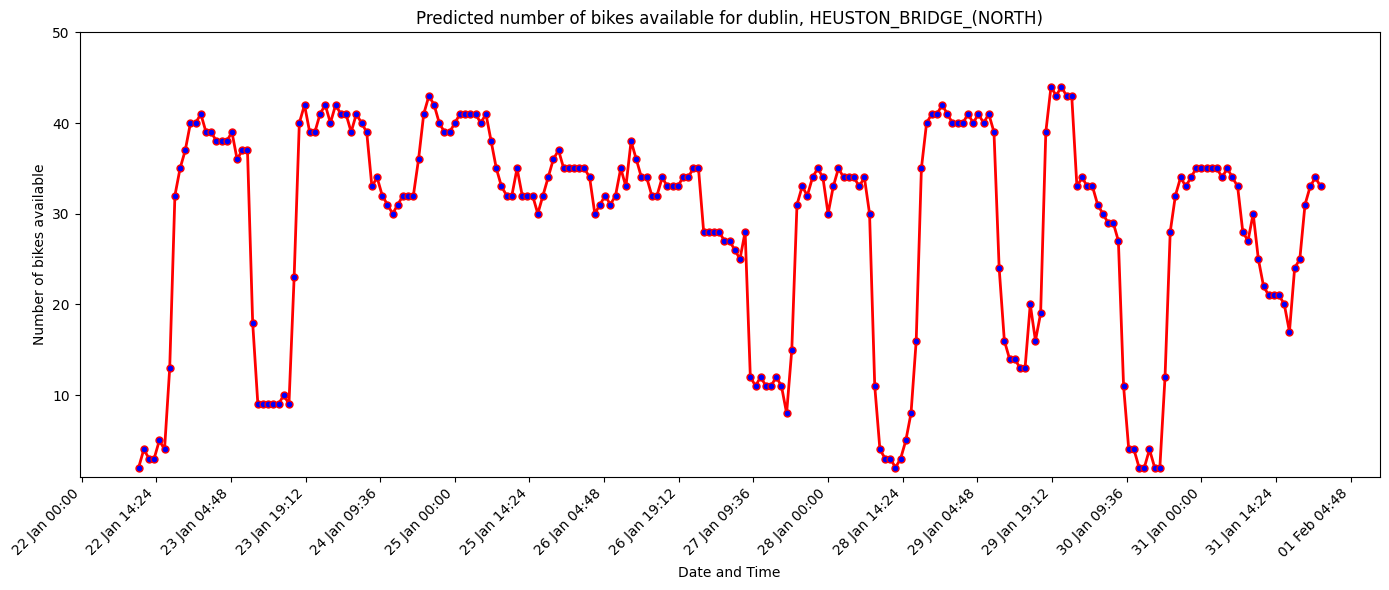

In [12]:
file_path = "docs/bike_availability_forecast.png"
plt = utils.plot_bike_availability_forecast(CITY, STATION, batch_data, file_path)
plt.show()

In [13]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='bike_availability_predictions',
    description='Bike availability prediction monitoring for ' + STATION.replace("_", " "),
    version=1,
    primary_key=["datetime", "city"],
    event_time="datetime"
)

In [15]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 100.00% |██████████| Rows 229/229 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: bike_availability_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1207494/jobs/named/bike_availability_predictions_1_offline_fg_materialization/executions


KeyboardInterrupt: 

In [16]:
# We will create a hindcast chart for only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.hours_before_forecast_time <= 24).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.64s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available,hours_before_forecast_time
0,2025-01-23 01:00:00+00:00,4.650000,1.574594,0.0,0.0,11.019764,30442.521484,2.9,dublin,1,3,1,39,15
1,2025-01-22 06:00:00+00:00,2.250000,-0.657853,0.0,0.0,7.754637,30252.697266,3.3,dublin,1,2,6,37,18
2,2025-01-22 05:00:00+00:00,2.100000,-0.883082,0.0,0.0,8.089993,30252.697266,3.3,dublin,1,2,5,36,17
3,2025-01-22 15:00:00+00:00,5.700000,2.753897,0.0,0.0,9.832680,30252.697266,0.9,dublin,1,2,15,5,5
4,2025-01-23 02:00:00+00:00,4.250000,0.940796,0.0,0.0,12.096214,30442.521484,2.9,dublin,1,3,2,38,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2024-12-28 06:00:00+00:00,8.689500,6.399599,0.0,0.0,11.931705,27194.826172,0.0,dublin,12,5,6,40,6
66,2024-12-28 08:00:00+00:00,8.639501,6.310997,0.0,0.0,12.456468,27194.826172,0.0,dublin,12,5,8,40,8
67,2024-12-29 00:00:00+00:00,7.939500,5.065456,0.0,0.0,13.619471,27249.105469,0.0,dublin,12,6,0,35,24
68,2024-12-28 17:00:00+00:00,8.789500,5.991804,0.0,0.0,15.070633,27194.826172,0.0,dublin,12,5,17,31,17


In [17]:
bike_fg = fs.get_feature_group(
    name='bike_data',
    version=1,
)
bike_df = bike_fg.read()

bike_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.49s) 


,datetime,station,num_bikes_available
0,2024-09-23 10:00:00+00:00,HEUSTON_BRIDGE_(NORTH),2.0
1,2023-10-07 13:00:00+00:00,HEUSTON_BRIDGE_(NORTH),29.0
2,2023-11-27 07:00:00+00:00,HEUSTON_BRIDGE_(NORTH),34.0
3,2024-01-22 22:00:00+00:00,HEUSTON_BRIDGE_(NORTH),35.0
4,2023-10-16 02:00:00+00:00,HEUSTON_BRIDGE_(NORTH),40.0
...,...,...,...
9593,2025-01-21 10:00:00+00:00,HEUSTON_BRIDGE_(NORTH),10.0
9594,2025-01-21 09:00:00+00:00,HEUSTON_BRIDGE_(NORTH),17.0
9595,2025-01-21 08:00:00+00:00,HEUSTON_BRIDGE_(NORTH),35.0
9596,2025-01-21 18:00:00+00:00,HEUSTON_BRIDGE_(NORTH),40.0


In [18]:
weather_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.12s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city
0,2024-11-17 07:00:00+00:00,6.6395,3.542508,0.0,0.0,13.091829,30647.093750,2.600000,dublin
1,2024-07-26 02:00:00+00:00,12.0395,9.959105,0.0,0.0,15.349684,57427.019531,0.900000,dublin
2,2024-08-02 09:00:00+00:00,18.9895,18.108223,0.0,0.0,19.469975,56053.718750,2.500000,dublin
3,2024-03-28 18:00:00+00:00,8.1395,6.004910,0.1,0.0,4.334974,46005.636719,1.300000,dublin
4,2024-01-09 08:00:00+00:00,3.7895,-1.855704,0.0,0.0,21.602999,28177.490234,0.000000,dublin
...,...,...,...,...,...,...,...,...,...
12715,2025-01-31 11:00:00+00:00,6.5000,3.481879,0.0,0.0,9.085988,32065.236328,5.700001,dublin
12716,2025-01-31 22:00:00+00:00,6.2500,1.161357,0.3,0.0,25.478743,32065.236328,5.700001,dublin
12717,2025-01-31 15:00:00+00:00,7.6500,4.674398,0.7,0.0,12.727921,32065.236328,5.700001,dublin
12718,2025-01-31 03:00:00+00:00,5.4000,0.109161,0.0,0.0,22.530937,32065.236328,5.700001,dublin


In [19]:
def backfill_predictions_for_monitoring(weather_fg, bike_df, monitor_fg, model):
    features_df = weather_fg.read()

    features_df["month"] = features_df["datetime"].dt.month
    features_df["weekday"] = features_df["datetime"].dt.weekday  # 0=Monday, 6=Sunday
    features_df["hour"] = features_df["datetime"].dt.hour

    features_df = pd.merge(features_df, bike_df[['datetime','num_bikes_available']], on="datetime")
    features_df = features_df.sort_values(by=['datetime'], ascending=True)
    features_df = features_df.tail(10*24)
    
    features_df['predicted_bikes_available'] = model.predict(features_df[['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'weekday', 'hour']])
    features_df['predicted_bikes_available'] = features_df['predicted_bikes_available'].apply(lambda x: round(x))

    features_df['hours_before_forecast_time'] = range(1, len(features_df) + 1)
    hindcast_df = features_df
    features_df = features_df.drop('num_bikes_available', axis=1)
    monitor_fg.insert(features_df, write_options={"wait_for_job": True})
    return hindcast_df

In [20]:
outcome_df = bike_df[['datetime', 'num_bikes_available']]
preds_df =  monitoring_df[['datetime', 'predicted_bikes_available']]

hindcast_df = pd.merge(preds_df, outcome_df, on="datetime")
hindcast_df = hindcast_df.sort_values(by=['datetime'])
print(len(hindcast_df))
hindcast_df

36


,datetime,predicted_bikes_available,num_bikes_available
35,2024-12-28 01:00:00+00:00,39,39.0
18,2024-12-28 02:00:00+00:00,40,39.0
28,2024-12-28 03:00:00+00:00,40,39.0
12,2024-12-28 04:00:00+00:00,39,39.0
20,2024-12-28 05:00:00+00:00,38,39.0
31,2024-12-28 06:00:00+00:00,40,39.0
13,2024-12-28 07:00:00+00:00,39,39.0
32,2024-12-28 08:00:00+00:00,40,39.0
26,2024-12-28 09:00:00+00:00,41,38.0
19,2024-12-28 10:00:00+00:00,38,37.0


In [21]:
outcome_df = outcome_df.sort_values(by=['datetime'])
outcome_df

,datetime,num_bikes_available
5695,2023-08-07 02:00:00+00:00,10.0
2161,2023-08-07 03:00:00+00:00,10.0
3422,2023-08-07 04:00:00+00:00,10.0
8312,2023-08-07 05:00:00+00:00,10.0
2192,2023-08-07 06:00:00+00:00,10.0
...,...,...
9587,2025-01-21 20:00:00+00:00,39.0
9583,2025-01-21 21:00:00+00:00,40.0
9578,2025-01-21 22:00:00+00:00,39.0
9589,2025-01-21 23:00:00+00:00,40.0


In [22]:
preds_df = preds_df.sort_values(by=['datetime'])
preds_df

,datetime,predicted_bikes_available
69,2024-12-28 01:00:00+00:00,39
52,2024-12-28 02:00:00+00:00,40
62,2024-12-28 03:00:00+00:00,40
46,2024-12-28 04:00:00+00:00,39
54,2024-12-28 05:00:00+00:00,38
...,...,...
10,2025-01-23 06:00:00+00:00,36
6,2025-01-23 07:00:00+00:00,37
42,2025-01-23 08:00:00+00:00,37
40,2025-01-23 09:00:00+00:00,18


In [23]:

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
print("Hindcast length: ", len(hindcast_df))
if len(hindcast_df) == 0:
    hindcast_df = backfill_predictions_for_monitoring(weather_fg, bike_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Hindcast length:  36


,datetime,predicted_bikes_available,num_bikes_available
35,2024-12-28 01:00:00+00:00,39,39.0
18,2024-12-28 02:00:00+00:00,40,39.0
28,2024-12-28 03:00:00+00:00,40,39.0
12,2024-12-28 04:00:00+00:00,39,39.0
20,2024-12-28 05:00:00+00:00,38,39.0
31,2024-12-28 06:00:00+00:00,40,39.0
13,2024-12-28 07:00:00+00:00,39,39.0
32,2024-12-28 08:00:00+00:00,40,39.0
26,2024-12-28 09:00:00+00:00,41,38.0
19,2024-12-28 10:00:00+00:00,38,37.0


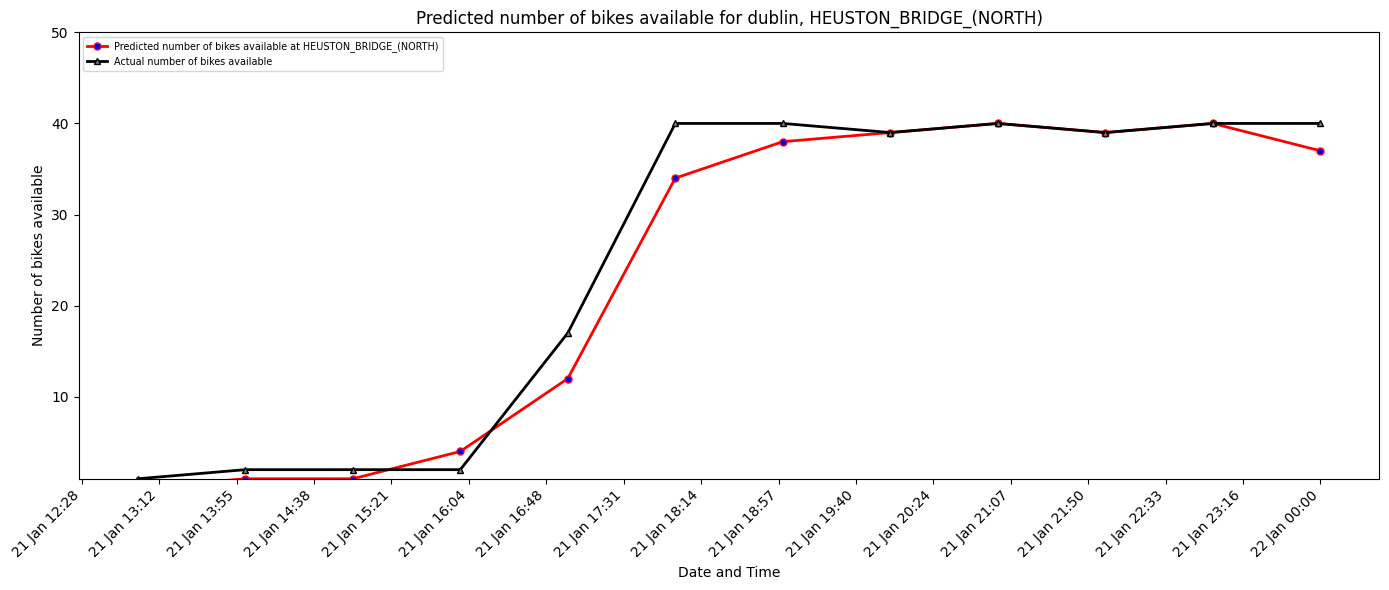

In [36]:
file_path = "docs/bike_availability_hindcast_10days.png"

today = datetime.datetime.now()
hindcast_df_10days = hindcast_df[hindcast_df['datetime'] >= today - datetime.timedelta(days=10)]

plt = utils.plot_bike_availability_forecast(CITY, STATION, hindcast_df_10days, file_path, hindcast=True)
plt.show()